# Theoretical maximum gini investigation

Theory
 - Verify that I can generate negative binomial data and regress its own parameters back out
 - Verify that negative binomial parameters can be regressed from a gamma mixture of poissons and related back to the original gamma parameters

Model outputs
 - Given a model's outputs, what is the expected gini if they are perfectly correct?
 - Apply this to our model's outputs
 - Use toy framework to generate data
   1. Calculate the gini of the generative model == expected maximum possible gini
   2. Train a model on all rating factors
   3. Calculate the theoretical gini of the model outputs if perfect
   4. Calculate the actual gini of the model outputs
   5. Repeat 3&4 for a model trained on impaired data

In [104]:
%load_ext autoreload
%aimport toy_data_generation, maths
%autoreload 1

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from model_toolbox.metric import gini_coefficient
from toy_data_generation import generate_poisson_data
from maths import scale_series
from param_dict_generation import generate_glm_list
from model_wrappers import try_models
# from scipy.stats import nbinom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
n = 0.5   # the number of successes required
p = 0.8  # the probability of success for an individual trial
size = 100000

In [32]:
rng = np.random.RandomState(808)
nbinom_sample = rng.negative_binomial(n, p, size)
pd.Series(nbinom_sample).value_counts()

0    89725
1     8709
2     1306
3      212
4       38
5        6
6        4
dtype: int64

In [33]:
expected_mu = n * (1 - p) / p
expected_mu

0.12499999999999997

In [34]:
actual_mu = nbinom_sample.mean()
actual_mu

0.12163

In [35]:
expected_var = expected_mu / p
expected_var

0.15624999999999994

In [36]:
actual_var = nbinom_sample.var()
actual_var

0.15263614309999998

In [37]:
fitted = sm.NegativeBinomial(nbinom_sample, np.ones(len(nbinom_sample))).fit()
fitted.summary()

Optimization terminated successfully.
         Current function value: 0.383563
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:               100000
Model:               NegativeBinomial   Df Residuals:                    99999
Method:                           MLE   Df Model:                            0
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:              -3.179e-10
Time:                        14:06:06   Log-Likelihood:                -38356.
converged:                       True   LL-Null:                       -38356.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1068      0.010   -207.536      0.000      -2.127      -2.087
alpha          2.0833      0.076     27.317      0.000       1.934       2.233
==============================================================================
"""

In [38]:
regressed_const, regressed_alpha = fitted.params

In [39]:
regressed_mu = np.exp(regressed_const)
regressed_mu

0.12162999999999977

In [40]:
# regressed_alpha = n / regressed_mu
regressed_alpha

2.083313633067688

Some experimental results to understand what the output of this regression / fit is telling us:

|n    |p    |alpha |
|-----|-----|------|
|2.5  |0.8  |0.3908|
|1.5  |0.8  |0.6725|
|0.5  |0.8  |2.0833|
|2.5  |0.2  |0.4018|
|1.5  |0.2  |0.6677|
|0.5  |0.2  |1.9954|

It looks as if the "alpha" we get out of this regression represents 1/n, and exp("const") gives the mean, mu.

To get the shape and scale parameters we can use:
 - shape param beta = r = n = 1/"alpha"
 - scale param alpha = mu / beta


## Can the gamma params be estimated with a Negative Binomial regression?

In [53]:
lams = np.random.gamma(shape=5, scale=0.005, size=1000000)

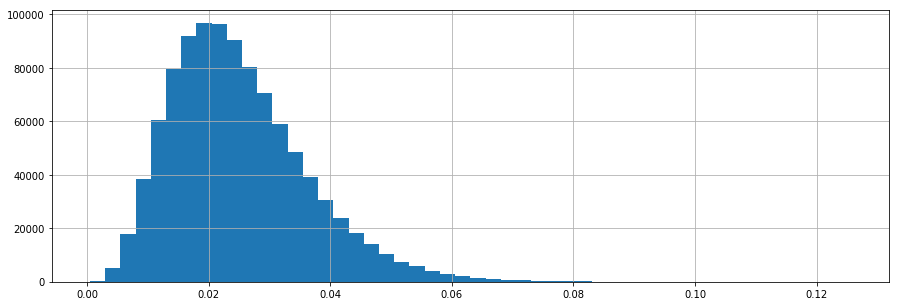

In [54]:
pd.Series(lams).hist(bins=50, figsize=(15,5), log=False);

In [55]:
response = np.random.poisson(lams)

In [56]:
pd.Series(response).value_counts()

0    975663
1     23986
2       350
3         1
dtype: int64

In [57]:
fitted = sm.NegativeBinomial(response, np.ones(len(response))).fit()

Optimization terminated successfully.
         Current function value: 0.116316
         Iterations: 4
         Function evaluations: 10
         Gradient evaluations: 10


In [58]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:              1000000
Model:               NegativeBinomial   Df Residuals:                   999999
Method:                           MLE   Df Model:                            0
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:              -1.967e-05
Time:                        14:11:55   Log-Likelihood:            -1.1632e+05
converged:                       True   LL-Null:                   -1.1631e+05
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7014      0.006   -579.456      0.000      -3.714      -3.689
alpha          0.2990      0.070      4.277      0.000       0.162       0.436
==============================================================================
"""

In [59]:
regressed_const, regressed_alpha = fitted.params
regressed_mu = np.exp(regressed_const)

In [60]:
regressed_shape = 1 / regressed_alpha
regressed_shape

3.3449299037328872

In [61]:
regressed_scale = regressed_mu / regressed_shape
regressed_scale

0.007381021638890071

FROM brain blitz:
 - Generate some toy data with known lambdas
 - Calculate the theorectical max gini on the data
 - Train a model on the data
 - Assuming predictions are 100% correct, calculate the theorectical max gini assuming the trained model is perfect
 - Calculate the actual gini of the model on the data

In [189]:
toy_X, toy_y, toy_lam = generate_poisson_data(1000000, 15,
                                              binary_fraction=0.4,
                                              terms=[(1, 1.0), (2, 15)],
                                              scale_to_range=(0.0001, 0.1),
                                              random_state=501)

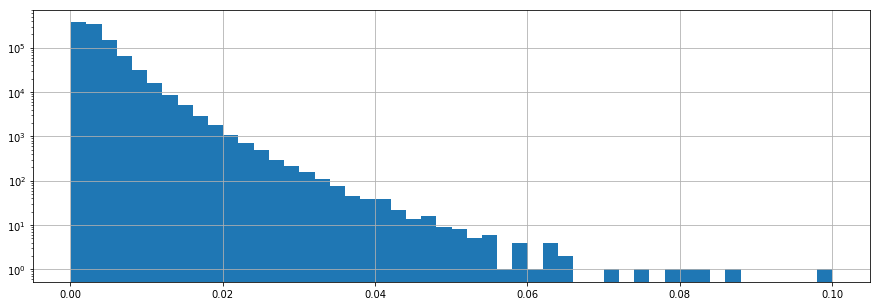

In [190]:
toy_lam.hist(bins=50, figsize=(15,5), log=True);

In [191]:
toy_y.value_counts()

0    996450
1      3543
2         7
Name: y_poisson, dtype: int64

In [192]:
# gini of actual generative distribution
gini_coefficient(toy_lam, np.ones(len(toy_lam)), toy_y)

0.4077318664605004

#### Train a GLM

In [193]:
# X_train, X_test, y_train, y_test = train_test_split(toy_X, toy_y, test_size=0.3, random_state=303)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

In [194]:
# model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
model = sm.GLM(toy_y, sm.add_constant(toy_X), family=sm.families.Poisson())

In [195]:
fitted = model.fit()

In [196]:
predictions = fitted.predict(sm.add_constant(toy_X))

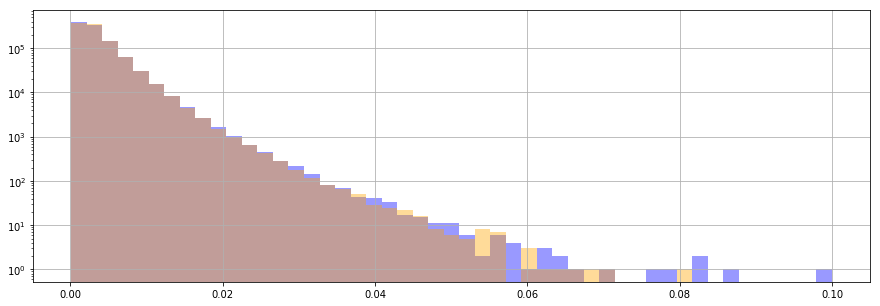

In [197]:
metamin = max(toy_lam.min(), predictions.min())
metamax = max(toy_lam.max(), predictions.max())
bins = np.linspace(metamin, metamax, 50)

ax = toy_lam.hist(bins=bins, figsize=(15,5), alpha=0.4, log=True, color='blue');
predictions.hist(bins=bins, figsize=(15,5), alpha=0.4, log=True, color='orange', ax=ax);

In [198]:
# Let's assume this model is perfect and re-sample a Poisson set of claims from it:
resampled_from_preds = np.random.poisson(predictions)
gini_coefficient(predictions, np.ones(len(predictions)), resampled_from_preds)

0.3955878100775194

This model has captured most of the variance (as evidenced by the very similar histograms) so has a very similar maximum theoretical gini.

In [199]:
# Let's see what the actual performance is:
gini_coefficient(predictions, np.ones(len(predictions)), toy_y)

0.39452029210008455

Even better than the truth! Amazing!

In [200]:
# drop 7 columns
toy_X_subset = toy_X.iloc[:, 4:12]

In [201]:
# Now let's impair the model by only giving it access to a subset of variables:
model_imp = sm.GLM(toy_y, sm.add_constant(toy_X_subset), family=sm.families.Poisson())

In [202]:
fitted_imp = model_imp.fit()

In [203]:
predictions_imp = fitted_imp.predict(sm.add_constant(toy_X_subset))

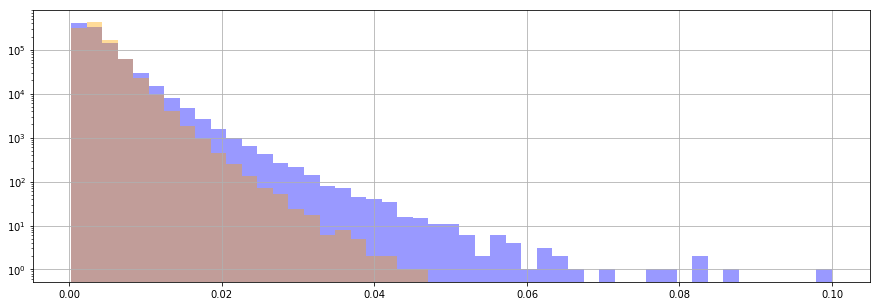

In [204]:
metamin = max(toy_lam.min(), predictions_imp.min())
metamax = max(toy_lam.max(), predictions_imp.max())
bins = np.linspace(metamin, metamax, 50)

ax = toy_lam.hist(bins=bins, figsize=(15,5), alpha=0.4, log=True, color='blue');
predictions_imp.hist(bins=bins, figsize=(15,5), alpha=0.4, log=True, color='orange', ax=ax);

In [205]:
# Let's assume this model is perfect and re-sample a Poisson set of claims from it:
resampled_from_preds = np.random.poisson(predictions_imp)
gini_coefficient(predictions_imp, np.ones(len(predictions_imp)), resampled_from_preds)

0.3171805545505938

This model has captured less variance so has a lower maximum theoretical gini.

In [206]:
# Let's see what the actual performance is:
gini_coefficient(predictions_imp, np.ones(len(predictions_imp)), toy_y)

0.3191034458813611

Not far off its theoretical maximum.

In [207]:
# drop 12 columns
toy_X_subset2 = toy_X.iloc[:, 5:8]

In [208]:
# Now let's impair the model by only giving it access to a subset of variables:
model_imp2 = sm.GLM(toy_y, sm.add_constant(toy_X_subset2), family=sm.families.Poisson())

In [209]:
fitted_imp2 = model_imp2.fit()

In [210]:
predictions_imp2 = fitted_imp2.predict(sm.add_constant(toy_X_subset2))

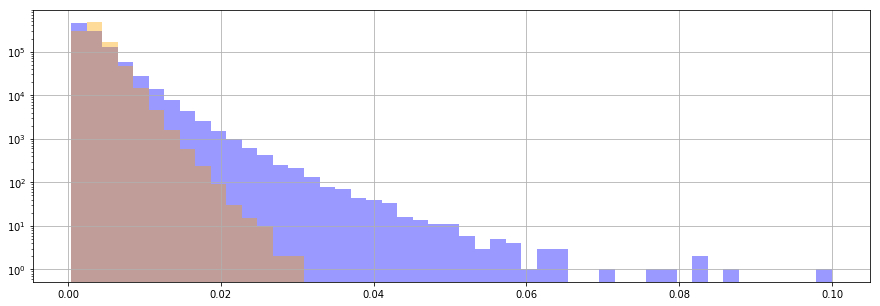

In [216]:
metamin = max(toy_lam.min(), predictions_imp2.min())
metamax = max(toy_lam.max(), predictions_imp2.max())
bins = np.linspace(metamin, metamax, 50)

ax = toy_lam.hist(bins=bins, figsize=(15,5), alpha=0.4, log=True, color='blue');
predictions_imp2.hist(bins=bins, figsize=(15,5), alpha=0.4, log=True, color='orange', ax=ax);

In [212]:
# Let's assume this model is perfect and re-sample a Poisson set of claims from it:
resampled_from_preds = np.random.poisson(predictions_imp2)
gini_coefficient(predictions_imp2, np.ones(len(predictions_imp2)), resampled_from_preds)

0.2755878086622806

This model has captured less variance so has a lower maximum theoretical gini.

In [213]:
# Let's see what the actual performance is:
gini_coefficient(predictions_imp2, np.ones(len(predictions_imp2)), toy_y)

0.267922080685971

Not far off its theoretical maximum, but below.